# 机器学习之决策树

#### 【简介】

决策树说通俗点就是一棵能够替我们做决策的树，或者说是我们人类在要做决策时脑回路的一种表现形式。

#### 【目录】

1. [什么是决策树](#1.-什么是决策树)
2. [信息熵与信息增益](#2.-信息熵与信息增益)
3. [使用ID3算法构建决策树](#3.-使用ID3算法构建决策树)
4. [信息增益率](#4.-信息增益率)
5. [基尼系数](#5.-基尼系数)
6. [预剪枝与后剪枝](#6.-预剪枝与后剪枝)
7. [鸢尾花识别](#7.-鸢尾花识别)

## 1. 什么是决策树

### 引例

在炎热的夏天，没有什么比冰镇后的西瓜更能令人感到心旷神怡的了。现在我要去水果店买西瓜，但什么样的西瓜能入我法眼呢？那根据某人的个人习惯，在挑西瓜时可能就有这样的脑回路：

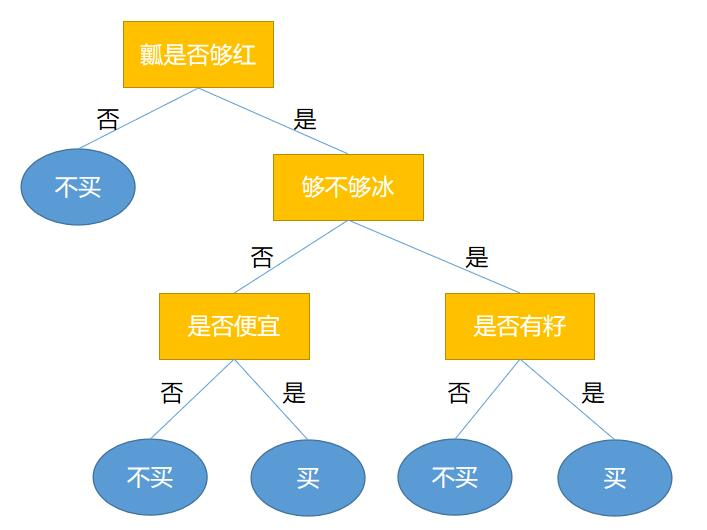

假设现在水果店里有3个西瓜，它们的属性如下：

| 编号 | 瓤是否够红 | 够不够冰 | 是否便宜 | 是否有籽 |
|:-- |:-- |:-- |:-- |:-- |
| 1 | 是 | 否 | 是 | 否 |
| 2 | 是 | 是 | 否 | 是 |
| 3 | 否 | 是 | 是 | 否 |

那么根据某人的脑回路，他会买1和2号西瓜。

其实某人的脑回路可以看成一棵树，并且这棵树能够帮助他对买不买西瓜这件事做决策，所以它就是一棵**决策树**。

### 决策树的相关概念

**决策树**是一种可以用于**分类**与**回归**的机器学习算法，但主要用于分类。用于分类的决策树是一种描述对实例进行分类的**树形结构**。决策树由**结点**和**边**组成，其中结点分为内部结点和叶子结点，**内部结点**表示一个**特征**或者**属性**，**叶子结点**表示**标签**（脑回路图中黄色的是内部结点，蓝色的是叶子结点）。

从代码角度来看，决策树其实可以看成是一堆if-else语句的集合，例如引例中的决策树完全可以看成是如下代码：

In [12]:
def decide_to_buy(wm):
    decision = None
    if wm['isRed']:
        if wm['isCold']:
            if wm['hasSeed']:
                decision = "买"
            else:
                decision = "不买"
        else:
            if wm['isCheap']:
                decision = "买"
            else:
                decision = "不买"
    else:
        decision = "不买"
    return decision

In [13]:
watermelons = [
    {'isRed': True, 'isCold': False, 'isCheap': True, 'hasSeed': False},
    {'isRed': True, 'isCold': True, 'isCheap': False, 'hasSeed': True},
    {'isRed': False, 'isCold': True, 'isCheap': True, 'hasSeed': False}
]

[decide_to_buy(wm) for wm in watermelons]

['买', '买', '不买']

因此决策树的一个非常大的优势就是模型的可理解性非常高，甚至可以用来挖掘数据中比较重要的信息。

那么如何构造出一棵好的决策树呢？其实构造决策树时会遵循一个指标，有的是按照**信息增益**来构建，如**ID3算法**；有的是**信息增益率**来构建，如**C4.5算法**；有的是按照**基尼系数**来构建的，如**CART算法**。但不管是使用哪种构建算法，决策树的构建过程通常都是一个**递归选择最优特征**，并**根据特征对训练集进行分割**，使得**对各个子数据集有一个最好的分类**的过程。

这一过程对应着对**特征空间的划分**，也对应着**决策树的构建**。一开始，构建决策树的根结点，将所有训练数据都放在根结点。选择一个最优特征，并按照这一特征将训练数据集分割成子集，使得各个子集有一个在当前条件下最好的分类。如果这些子集已经能够被基本正确分类，那么构建叶子结点，并将这些子集分到所对应的叶结点中去；如果还有子集不能被基本正确分类，那么就对这些子集选择新的最优特征，继续对其进行分割，并构建相应的结点。如此递归进行下去，直至所有训练数据子集被基本正确分类，或者没有合适的特征为止。最后每个子集都被分到叶子结点上，即都有了明确的类别。这就构建出了一棵决策树。

## 2. 信息熵与信息增益

### 任务描述

掌握什么是信息增益，完成计算信息增益的程序设计。

### 相关知识

为了完成本任务，需要掌握：

- 信息熵
- 条件熵
- 信息增益

#### 信息熵

信息是个很抽象的概念。人们常常说信息很多，或者信息较少，但却很难说清楚信息到底有多少。比如一本五十万字的中文书到底有多少信息量。

直到1948年，香农提出了“信息熵”的概念，才解决了**对信息的量化度量**问题。**信息熵**这个词是香农从热力学中借用过来的。热力学中的热熵是表示分子状态混乱程度的物理量。香农用信息熵的概念来**描述信源的不确定性**。**信源的不确定性越大，信息熵也越大**。

从机器学习的角度来看，**信息熵表示的是信息量的期望值**。如果数据集中的数据需要被分成多个类别，则信息量$I(x_i)$的定义如下(其中$x_i$表示多个类别中的第i个类别，$p(x_i)$为数据集中类别为$x_i$的数据在数据集中出现的概率)：

$$
I(X_i) = -\log_2 p(x_i)
$$

由于信息熵是信息量的期望值，所以信息熵H(X)的定义如下(其中n为数据集中类别的数量)：

$$
H(X) = - \sum_{i=1}^n p(x_i)\log_2 p(x_i)
$$

从这个公式也可以看出，如果概率是0或者是1的时候，熵就是0（因为这种情况下随机变量的不确定性是最低的）。那如果概率是0.5，也就是五五开的时候，此时熵达到最大，也就是1。（就像扔硬币，你永远都猜不透你下次扔到的是正面还是反面，所以它的不确定性非常高）。所以呢，**熵越大，不确定性就越高**。

#### 条件熵

在实际的场景中，可能需要研究数据集中某个特征等于某个值时的信息熵等于多少，这个时候就需要用到条件熵。条件熵$H(X|Y)$表示特征$Y$为某个值的条件下，类别为$X$的熵。条件熵的计算公式如下：

$$
H(X|Y) = \sum_{i=1}^n p_i H(X = x_i|Y)
$$

当然条件熵的性质也和熵的性质一样，概率越确定，条件熵就越小，概率越五五开，条件熵就越大。

#### 信息增益

现在已经知道了什么是熵，什么是条件熵。接下来就可以看看什么是信息增益了。所谓的信息增益就是表示我已知条件X后能得到信息Y的不确定性的减少程度。

就好比，我在玩读心术。你心里想一件东西，我来猜。我已开始什么都没问你，我要猜的话，肯定是瞎猜。这个时候我的熵就非常高。然后我接下来我会去试着问你是非题，当我问了是非题之后，我就能减小猜测你心中想到的东西的范围，这样其实就是减小了我的熵。那么我熵的减小程度就是我的信息增益。

所以信息增益如果套上机器学习的话就是，如果把特征A对训练集D的信息增益记为$g(D,A)$的话，那么$g(D,A)$的计算公式就是：

$$
g(D,A) = H(D) - H(D,A)
$$

为了更好的解释**熵**，**条件熵**，**信息增益**的计算过程，下面通过示例来描述。

假设我现在有这一个数据集，第一列是编号，第二列是性别，第三列是活跃度，第四列是客户是否流失的标签（0表示未流失，1表示流失）。

| 编号 | 性别 | 活跃度 | 是否流失 |
|:-- |:-- |:-- |:-- |
| 1 | 男 | 高 | 0 |
| 2 | 女 | 中 | 0 |
| 3 | 男 | 低 | 1 |
| 4 | 女 | 高 | 0 |
| 5 | 男 | 高 | 0 |
| 6 | 男 | 中 | 0 |
| 7 | 男 | 中 | 1 |
| 8 | 女 | 中 | 0 |
| 9 | 女 | 低 | 1 |
| 10 | 女 | 中 | 0 |
| 11 | 女 | 高 | 0 |
| 12 | 男 | 低 | 1 |
| 13 | 女 | 低 | 1 |
| 14 | 男 | 高 | 0 |
| 15 | 男 | 高 | 0 |

假如要算性别和活跃度这两个特征的**信息增益**的话，首先要先算总的**熵**和**条件熵**。总的熵其实非常好算，就是把**标签作为随机变量X**。上表中标签只有两种（0和1）因此随机变量X的取值只有0或者1。所以要计算熵就需要先分别计算标签为0的概率和标签为1的概率。从表中能看出标签为0的数据有10条，所以标签为0的概率等于2/3。标签为1的概率为1/3。所以熵为：

$$
H(X) = - \sum_{i=1}^n p(x_i)\log_2 p(x_i) =  
- p(X=0) \times \log_2 p(X=0) - p(X=1) \times \log_2 p(X=1) = 
- (1/3) \times log_2(1/3) - (2/3) \times log(2/3) = 0.9182
$$

接下来就是**条件熵**的计算，以**性别**为**男**的熵为例。表格中性别为男的数据有8条，这8条数据中有3条数据的标签为1，有5条数据的标签为0。所以根据条件熵的计算公式能够得出该条件熵为：

$$
H(X|Y) = \sum_{i=1}^n H(X = x_i|Y) = 
- (3/8) \times \log_2(3/8) - (5/8) \times \log_2(5/8) = 0.9543
$$

根据上述的计算方法可知，**总熵**为：

$$
H(X) = - (5/15) \times log_2(5/15) - (10/15) \times log(10/15) = 0.9182
$$

**性别**为**男**的**条件熵**为：

$$
H(X|性别=男) = - (3/8) \times \log_2(3/8) - (5/8) \times \log_2(5/8) = 0.9543
$$

**性别**为**女**的**条件熵**为：
$$
H(X|性别=女) = - (2/7) \times \log_2(2/7) - (5/7) \times \log_2(5/7) = 0.8631
$$

**活跃度**为**低**的**条件熵**为：

$$
H(X|活跃度=低) = -(4/4) \times \log_2(4/4) - 0 = 0
$$

**活跃读**为**中**的**条件熵**为：

$$
H(X|活跃度=中) = -(1/5) \times \log_2(1/5) - (4/5) \times \log_2(4/5) = 0.7219
$$

**活跃度**为**高**的**条件熵**为：

$$
H(X|活跃度=高) = -(6/6) \times log_2(6/6) - 0 = 0
$$

现在有了**总熵**和**条件熵**之后就能算出性别和活跃度这两个特征的**信息增益**了。

**性别**的**信息增益**：

$$
g(D,性别) = H(D) - H(D,性别) = \\
H(X) - (P(性别=男) * H(X|性别=男) - (P(性别=女) * H(X|性别=女) = \\
0.9182 - (8/15) * 0.9543 - (7/15) * 0.8631 = 0.0064
$$

**活跃度**的**信息增益**：

$$
g(D,活跃度) = H(D) - H(D,活跃度) = \\
H(X) - P(活跃度=高) * H(X|活跃度=高) - P(活跃度=中) * H(X|活跃度=中) - P(活跃度=低) * H(X|活跃度=低) = \\
0.9182 - (6/15) * 0 - (5/15) * 0.7219 - (4/15) * 0 = 0.6776
$$

那信息增益算出来之后有什么意义呢？回到读心术的问题，为了我能更加准确的猜出你心中所想，肯定是问的问题越好就能猜得越准！换句话来说我肯定是要想出一个**信息增益最大**（减少不确定性程度最高）的问题来问你。其实ID3算法也是这么想的。**ID3算法**的**思想**是从训练集D中**计算每个特征的信息增益**，然后看哪个**最大**就选哪个**作为当前结点**。然后继续重复刚刚的步骤来构建决策树。

### 实操练习

#### 编程要求

根据提示，补充下列代码，完成`calc_info_gain`函数实现信息增益的计算。

`calc_info_gain`函数中的参数:

- `feature`：特征集，类型为`ndarray`
- `label`：标签，类型为`ndarray`
- `index`：`feature`特征列的索引,即`features`中第几个特征，如`index:0`表示计算第一个特征的信息增益。

#### 测试说明

测试输入：

`{'feature':[[0, 1], [1, 0], [1, 2], [0, 0], [1, 1]], 'label':[0, 1, 0, 0, 1], 'index': 0}`

预期输出：

`0.419973`

【提示】计算log可以使用NumPy中的log2函数

In [14]:
import numpy as np

def calc_info_gain(feature, label, index):
    '''
    计算信息增益
    :param feature: 数据集中的特征，类型为ndarray，类型为ndarray
    :param label: 数据集中的标签，类型为ndarray，类型为ndarray
    :param index: feature特征列的索引,即feature中第几个特征
    :return: 信息增益，类型float
    '''
    #*********** Begin ***********#
    # 计算熵
    def calc_info_entropy(feature, label):
        '''
        计算信息熵
        :param feature:数据集中的特征，类型为ndarray
        :param label:数据集中的标签，类型为ndarray
        :return:信息熵，类型float
        '''
        label_set = set(label)
        result = 0
        for l in label_set:
            count = 0
            for j in range(len(label)):
                if label[j] == l:
                    count += 1
            # 计算标签在数据集中出现的概率
            p = count / len(label)
            # 计算熵
            result -= p * np.log2(p)
        return result
    # 计算条件熵
    def calc_HDA(feature, label, index, value):
        '''
        计算信息熵
        :param feature:数据集中的特征，类型为ndarray
        :param label:数据集中的标签，类型为ndarray
        :param index:需要使用的特征列索引，类型为int
        :param value:index所表示的特征列中需要考察的特征值，类型为int
        :return:信息熵，类型float
        '''
        count = 0
        # sub_feature和sub_label表示根据特征列和特征值分割出的子数据集中的特征和标签
        sub_feature = []
        sub_label = []
        for i in range(len(feature)):
            if feature[i][index] == value:
                count += 1
                sub_feature.append(feature[i])
                sub_label.append(label[i])
        pHA = count / len(feature)
        e = calc_info_entropy(sub_feature, sub_label)
        return pHA * e
    
    base_e = calc_info_entropy(feature, label)
    f = np.array(feature)
    # 得到指定特征列的值的集合
    f_set = set(f[:, index])
    sum_HDA = 0
    # 计算条件熵
    for value in f_set:
        sum_HDA += calc_HDA(feature, label, index, value)
    # 计算信息增益
    return base_e - sum_HDA
    #*********** End *************#

In [16]:
input_data = {
    'feature': [[0, 1], [1, 0], [1, 2], [0, 0], [1, 1]],
    'label': [0, 1, 0, 0, 1],
    'index': 0
}

calc_info_gain(input_data['feature'], input_data['label'], input_data['index'])

0.4199730940219749

## 3. 使用ID3算法构建决策树

### 任务描述

根据**ID3算法**描述实现决策树的fit和predict方法。

### 相关知识

为了完成本任务，需要掌握：

- ID3算法构造决策树的流程

- 如何使用构造好的决策树进行预测

#### ID3算法

**ID3算法**其实就是**依据特征的信息增益**来**构建树**的。其大致步骤就是从根结点开始，对结点计算所有可能的特征的信息增益，然后选择信息增益最大的特征作为结点的特征，由该特征的不同取值建立子结点，然后对子结点递归执行上述的步骤直到信息增益很小或者没有特征可以继续选择为止。

因此，ID3算法伪代码如下：

#### 使用决策树进行预测

决策树的预测思想非常简单，假设现在已经构建出了一棵用来决策是否买西瓜的决策树。

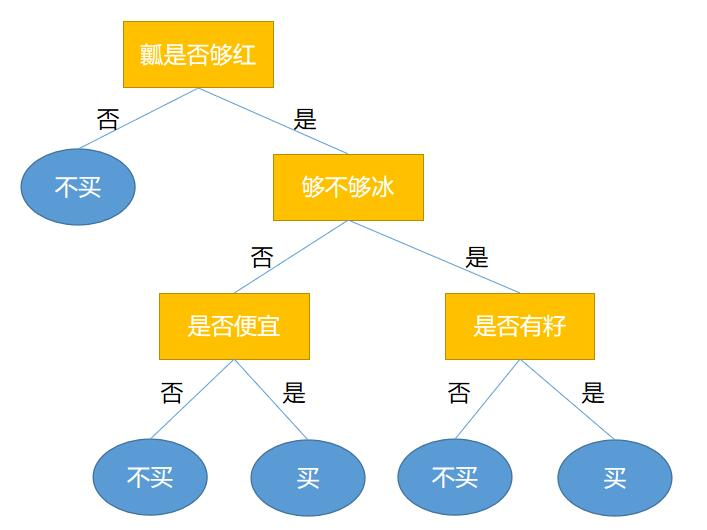

并假设现在在水果店里有这样一个西瓜，其属性如下：

| 瓤是否够红 | 够不够冰 | 是否便宜 | 是否有籽 |
|:-- |:-- |:-- |:--|
| 是 | 否 | 是 | 否 |

那买不买这个西瓜呢？只需把西瓜的属性代入决策树即可。决策树的根结点是瓤是否够红，所以就看西瓜的属性，经查看发现够红，因此接下来就看够不够冰。而西瓜不够冰，那么看是否便宜。发现西瓜是便宜的，所以这个西瓜是可以买的。

因此使用决策树进行预测的伪代码也比较简单，伪代码如下：

### 实操练习

#### 编程要求

填写`fit(self, feature, label)`函数，实现ID3算法，要求决策树保存在`self.tree`中。其中：

- `feature`：训练集数据，类型为`ndarray`，数值全为整数；

- `label`：训练集标签，类型为`ndarray`，数值全为整数。

填写`predict(self, feature)`函数，实现预测功能，并将标签返回，其中：

- `feature`：测试集数据，类型为`ndarray`，数值全为整数。（PS：feature中有多条数据）

#### 测试说明

输出预测准确率（应高于0.92)

In [26]:
import numpy as np

class DecisionTree(object):
    # 构造方法
    def __init__(self):
        # 决策树模型
        self.tree = {}

    # 计算信息增益
    def calc_info_gain(self, feature, label, index):
        '''
        计算信息增益
        :param feature: 数据集中的特征，类型为ndarray，类型为ndarray
        :param label: 数据集中的标签，类型为ndarray，类型为ndarray
        :param index: feature特征列的索引,即feature中第几个特征
        :return: 信息增益，类型float
        '''
        # 计算熵
        def calc_info_entropy(label):
            '''
            计算信息熵
            :param feature: 数据集中的特征，类型为ndarray
            :param label: 数据集中的标签，类型为ndarray
            :return: 信息熵，类型float
            '''
            label_set = set(label)
            result = 0
            for l in label_set:
                count = 0
                for j in range(len(label)):
                    if label[j] == l:
                        count += 1
                # 计算标签在数据集中出现的概率
                p = count / len(label)
                # 计算熵
                result -= p * np.log2(p)
            return result
        
        # 计算条件熵
        def calc_HDA(feature, label, index, value):
            '''
            计算信息熵
            :param feature: 数据集中的特征，类型为ndarray
            :param label: 数据集中的标签，类型为ndarray
            :param index: 需要使用的特征列索引，类型为int
            :param value: index所表示的特征列中需要考察的特征值，类型为int
            :return: 信息熵，类型float
            '''
            count = 0
            # sub_feature和sub_label表示根据特征列和特征值分割出的子数据集中的特征和标签
            sub_feature = []
            sub_label = []
            for i in range(len(feature)):
                if feature[i][index] == value:
                    count += 1
                    sub_feature.append(feature[i])
                    sub_label.append(label[i])
            pHA = count / len(feature)
            e = calc_info_entropy(sub_label)
            return pHA * e

        base_e = calc_info_entropy(label)
        f = np.array(feature)
        # 得到指定特征列的值的集合
        f_set = set(f[:, index])
        sum_HDA = 0
        # 计算条件熵
        for value in f_set:
            sum_HDA += calc_HDA(feature, label, index, value)
        # 计算信息增益
        return base_e - sum_HDA
    
    # 获得信息增益最高的特征
    def get_best_feature(self, feature, label):
        max_infogain = 0
        best_feature = 0
        for i in range(len(feature[0])):
            infogain = self.calc_info_gain(feature, label, i)
            if infogain > max_infogain:
                max_infogain = infogain
                best_feature = i
        return best_feature
    
    def create_tree(self, feature, label):
        # 样本里都是同一个label没必要继续分叉了
        if len(set(label)) == 1:
            return label[0]
        # 样本中只有一个特征或者所有样本的特征都一样的话就看哪个label的票数高
        if len(feature[0]) == 1 or len(np.unique(feature, axis=0)) == 1:
            vote = {}
            for l in label:
                if l in vote.keys():
                    vote[l] += 1
                else:
                    vote[l] = 1
            max_count = 0
            vote_label = None
            for k, v in vote.items():
                if v > max_count:
                    max_count = v
                    vote_label = k
            return vote_label
        # 根据信息增益拿到特征的索引
        best_feature = self.get_best_feature(feature, label)
        tree = {best_feature: {}}
        f = np.array(feature)
        # 拿到bestfeature的所有特征值
        f_set = set(f[:, best_feature])
        # 构建对应特征值的子样本集sub_feature, sub_label
        for v in f_set:
            sub_feature = []
            sub_label = []
            for i in range(len(feature)):
                if feature[i][best_feature] == v:
                    sub_feature.append(feature[i])
                    sub_label.append(label[i])
            # 递归构建决策树
            tree[best_feature][v] = self.create_tree(sub_feature, sub_label)
        return tree
    
    # 获得信息增益最高的特征
    def get_best_feature(self, feature, label):
        max_infogain = 0
        best_feature = 0
        for i in range(len(feature[0])):
            infogain = self.calc_info_gain(feature, label, i)
            if infogain > max_infogain:
                max_infogain = infogain
                best_feature = i
        return best_feature
    
    # 创建决策树
    def create_tree(self, feature, label):
        # 样本里都是同一个label没必要继续分叉了
        if len(set(label)) == 1:
            return label[0]
        # 样本中只有一个特征或者所有样本的特征都一样的话就看哪个label的票数高
        if len(feature[0]) == 1 or len(np.unique(feature, axis=0)) == 1:
            vote = {}
            for l in label:
                if l in vote.keys():
                    vote[l] += 1
                else:
                    vote[l] = 1
            max_count = 0
            vote_label = None
            for k, v in vote.items():
                if v > max_count:
                    max_count = v
                    vote_label = k
            return vote_label
        # 根据信息增益拿到特征的索引
        best_feature = self.get_best_feature(feature, label)
        tree = {best_feature: {}}
        f = np.array(feature)
        # 拿到bestfeature的所有特征值
        f_set = set(f[:, best_feature])
        # 构建对应特征值的子样本集sub_feature, sub_label
        for v in f_set:
            sub_feature = []
            sub_label = []
            for i in range(len(feature)):
                if feature[i][best_feature] == v:
                    sub_feature.append(feature[i])
                    sub_label.append(label[i])
            # 递归构建决策树
            tree[best_feature][v] = self.create_tree(sub_feature, sub_label)
        return tree
    
    # 训练决策树模型，拟合数据集
    def fit(self, feature, label):
        '''
        :param feature: 训练集数据，类型为ndarray
        :param label:训练集标签，类型为ndarray
        :return: None
        '''
        #************* Begin ************#
        self.tree = self.create_tree(feature, label)
        #************* End **************#
    
    # 使用决策树模型进行预测
    def predict(self, feature):
        '''
        :param feature:测试集数据，类型为ndarray
        :return:预测结果，如np.array([0, 1, 2, 2, 1, 0])
        '''
        #************* Begin ************#
        result = []
        
        def classify(tree, feature):
            if not isinstance(tree, dict):
                return tree
            t_index, t_value = list(tree.items())[0]
            f_value = feature[t_index]
            if isinstance(t_value, dict):
                classLabel = classify(tree[t_index][f_value], feature)
                return classLabel
            else:
                return t_value
            
        for f in feature:
            result.append(classify(self.tree, f))

        return np.array(result)
        #************* End **************#

In [27]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 测试模型性能
iris = datasets.load_iris()
X = iris.data.astype(int)
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=2
)
dt = DecisionTree()
dt.fit(X_train, y_train)
predict = dt.predict(X_test)
acc = accuracy_score(y_test, predict)

print('预测正确率：{:.2f}'.format(acc))

预测正确率：0.93


## 4. 信息增益率

### 任务描述

实现信息增益率的计算

### 相关知识

为了完成本任务，需要掌握：信息增益率

#### 信息增益率

由于在使用信息增益这一指标进行划分时，更喜欢可取值数量较多的特征。为了减少这种偏好可能带来的不利影响，提出了使用**信息增益率**这一指标来选择最优划分属性。

信息增益率的数学定义为如下，其中$D$表示数据集，$a$表示数据集中的某一列，$Gain(D,a)$表示$D$中$a$的信息增益，$V$表示$a$这一列中取值的集合，$v$表示$V$中的某种取值，$|D|$表示$D$中样本的数量，$|D^v|$表示$D$中$a$这一列中值等于$v$的数量。

$$
GainRatio(D,a) = \frac{Gain(D,a)}{-\sum_{v=1}^V \frac{|D^v|}{|D|}\log_2\frac{|D^v|}{|D|}}
$$

从公式可以看出，信息增益率很好算，只是用信息增益除以另一个分母，该分母通常称为固有值。以第2节的数据集为例：

| 编号 | 性别 | 活跃度 | 是否流失 |
|:-- |:-- |:-- |:-- |
| 1 | 男 | 高 | 0 |
| 2 | 女 | 中 | 0 |
| 3 | 男 | 低 | 1 |
| 4 | 女 | 高 | 0 |
| 5 | 男 | 高 | 0 |
| 6 | 男 | 中 | 0 |
| 7 | 男 | 中 | 1 |
| 8 | 女 | 中 | 0 |
| 9 | 女 | 低 | 1 |
| 10 | 女 | 中 | 0 |
| 11 | 女 | 高 | 0 |
| 12 | 男 | 低 | 1 |
| 13 | 女 | 低 | 1 |
| 14 | 男 | 高 | 0 |
| 15 | 男 | 高 | 0 |

根据第2节已经知道，性别的信息增益为$0.0064$，设a为性别，则有$Gain(D,a)=0.0064$。由根据数据可知，$V=2$，假设当$v=1$时表示性别为男，$v=2$时表示性别为女，则有$|D| = 15$，$|D^1| = 8$，$∣D^2∣ = 7$。因此根据信息增益率的计算公式可知$GainRatio(D,a)=0.0642$。同理可以算出活跃度的信息增益率为$0.4328$。

### 实操练习

#### 编程要求

根据提示，补充下列代码，完成`calc_info_gain_ratio`函数实现信息增益率的计算。

`calc_info_gain_ratio`函数中的参数:

- `feature`：特征集，类型为ndarray
- `label`：标签，类型为ndarray
- `index`：feature特征列的索引,即features中第几个特征，如index:0表示计算第一个特征的信息增益率。



#### 测试说明

测试输入：`{'feature':[[0, 1], [1, 0], [1, 2], [0, 0], [1, 1]], 'label':[0, 1, 0, 0, 1], 'index': 0}`

预期输出：`0.432538`

【提示】计算log可以使用NumPy中的log2函数

In [28]:
def calc_info_gain_ratio(feature, label, index):
    '''
    计算信息增益率
    :param feature: 数据集中的特征，类型为ndarray，类型为ndarray
    :param label: 数据集中的标签，类型为ndarray，类型为ndarray
    :param index: feature特征列的索引,即feature中第几个特征
    :return: 信息增益率，类型float
    '''

    #********* Begin *********#
    info_gain = calc_info_gain(feature, label, index)
    unique_value = list(set(feature[:, index]))
    IV = 0
    for value in unique_value:
        len_v = np.sum(feature[:, index] == value)
        IV -= (len_v / len(feature)) * np.log2((len_v / len(feature)))
    return info_gain/IV
    #********* End *********#

In [36]:
input_data = {
    'feature': [[0, 1], [1, 0], [1, 2], [0, 0], [1, 1]],
    'label': [0, 1, 0, 0, 1],
    'index': 0
}

calc_info_gain_ratio(
    np.array(input_data['feature']), 
    np.array(input_data['label']), 
    input_data['index']
)

0.4325380677663126

## 5. 基尼系数

### 任务描述

实现基尼系数的计算

### 相关知识

为了完成本任务，需要掌握：基尼系数。

#### 基尼系数

在**ID3算法**中我们使用了**信息增益**来选择特征，信息增益大的优先选择。在**C4.5算法**中，采用了**信息增益率**来选择特征，以减少信息增益容易选择特征值多的特征的问题。但是无论是ID3还是C4.5,都是基于信息论的熵模型，这里面会涉及大量的对数运算。能不能简化模型同时也不至于完全丢失熵模型的优点呢？当然有！那就是**基尼系数**！

**CART算法**使用**基尼系数**来代替信息增益率，**基尼系数代表了模型的不纯度**，基尼系数越小，则不纯度越低，特征越好。这和信息增益与信息增益率是相反的(它们都是越大越好)。

**基尼系数**的**数学定义**为如下，其中$D$表示数据集，$p_k$表示$D$中第$k$个类别在$D$中所占比例。

$$
Gini(D) = 1 - \sum_{k=1}^{|y|} p_k^2
$$

从公式可以看出，相比于信息增益和信息增益率，基尼系数计算起来更加简单。还以第2节的数据集为例：

| 编号 | 性别 | 活跃度 | 是否流失 |
|:-- |:-- |:-- |:-- |
| 1 | 男 | 高 | 0 |
| 2 | 女 | 中 | 0 |
| 3 | 男 | 低 | 1 |
| 4 | 女 | 高 | 0 |
| 5 | 男 | 高 | 0 |
| 6 | 男 | 中 | 0 |
| 7 | 男 | 中 | 1 |
| 8 | 女 | 中 | 0 |
| 9 | 女 | 低 | 1 |
| 10 | 女 | 中 | 0 |
| 11 | 女 | 高 | 0 |
| 12 | 男 | 低 | 1 |
| 13 | 女 | 低 | 1 |
| 14 | 男 | 高 | 0 |
| 15 | 男 | 高 | 0 |

从表格可以看出，$D$中总共有$2$个类别，设类别为$0$的比例为$p_1$，则有$p_1=10/15$。设类别为1的比例为$p_2$，则有$p_2=5/15$。根据基尼系数的公式可知$Gini(D)=1−(p_1^2+p_2^2)=0.4444$。

上面是基于数据集$D$的基尼系数的计算方法，那么基于数据集$D$与特征$a$的基尼系数怎样计算呢？其实和信息增益率的套路差不多。计算公式如下：

$$
Gini(D,a) = \sum_{v=1}^V \frac{|D^v|}{|D|} Gini(D^v)
$$

还是以用户流失的数据为例，现在算一算性别的基尼系数。设性别男为$v=1$，性别女为$v=2$则有$|D|=15$，$|D^1|=8$，$|D^2|=7$，$Gini(D^1)=0.46875$，$Gini(D^2)=0.40816$。所以$Gini(D,a)=0.44048$。

### 实操练习

#### 编程要求

根据提示，补充下列代码，完成`calc_gini`函数以实现基尼系数的计算。

`calc_gini`函数中的参数:

- `feature`：特征集，类型为`ndarray`
- `label`：标签，类型为`ndarray`
- `index`：feature特征列的索引,即feature中第几个特征，如index:0表示计算第一个特征的基尼系数。

#### 测试说明

测试输入：`{'feature':[[0, 1], [1, 0], [1, 2], [0, 0], [1, 1]], 'label':[0, 1, 0, 0, 1], 'index': 0}`

预期输出：`0.266667`

In [ ]:
import numpy as np

def calc_gini(feature, label, index):
    '''
    计算基尼系数
    :param feature: 数据集中的特征，类型为ndarray，类型为ndarray
    :param label: 数据集中的标签，类型为ndarray，类型为ndarray
    :param index: feature特征列的索引,即feature中第几个特征
    :return: 信息增益，类型float
    '''
    #********* Begin *********#
    def _gini(label):
        unique_label = list(set(label))
        gini = 1
        for l in unique_label:
            p = np.sum(label == l)/len(label)
            gini -= p**2
        return gini
    
    unique_value = list(set(feature[:, index]))
    gini = 0
    
    for value in unique_value:
        len_v = np.sum(feature[:, index] == value)
        gini += (len_v/len(feature))*_gini(label[feature[:, index] == value])
    return gini

In [43]:
input_data = {
    'feature': np.array([[0, 1], [1, 0], [1, 2], [0, 0], [1, 1]]),
    'label': np.array([0, 1, 0, 0, 1]),
    'index': 0
}

calc_gini(input_data['feature'], input_data['label'], input_data['index'])

0.26666666666666666

## 6. 预剪枝与后剪枝

### 任务描述

使用剪枝技术实现DecisionTree类的fit和predict方法。

### 相关知识

为了完成本任务，需要掌握：

- 为什么需要剪枝
- 预剪枝
- 后剪枝

#### 为什么需要剪枝

决策树的生成是递归地去构建决策树，直到不能继续下去为止。这样产生的树往往对训练数据有很高的分类准确率，但对未知的测试数据进行预测就没有那么准确了，也就是所谓的**过拟合**。

**决策树**容易**过拟合的原因**是在构建决策树的过程时会过多地考虑如何提高对训练集中的数据的分类准确率，从而会构建出非常复杂的决策树（树的宽度和深度都比较大）。在之前的实训中已经提到过，**模型**的**复杂度越高**，模型就**越容易**出现**过拟合**的现象。所以**简化决策树的复杂度**能够有效地**缓解过拟合**现象，而简化决策树最常用的方法就是**剪枝**。剪枝分为**预剪枝**与**后剪枝**。

#### 预剪枝

**预剪枝**的**核心思想**是在决策树生成过程中，对每个结点在划分前先进行一个评估，若当前结点的划分不能带来决策树泛化性能提升，则停止划分并将当前结点标记为叶结点。

想要**评估决策树算法的泛化性能**如何，方法很简单。可以将**训练数据集**中**随机取出一部分**作为**验证数据集**，然后在用训练数据集对每个结点进行划分之前用当前状态的决策树计算出在验证数据集上的正确率。正确率越高说明决策树的泛化性能越好，如果在划分结点的时候发现泛化性能有所下降或者没有提升时，说明应该停止划分，并用投票计数的方式将当前结点标记成叶子结点。

举个例子，假如上一关中所提到的用来决定是否买西瓜的决策树模型已经出现过拟合的情况，模型如下：

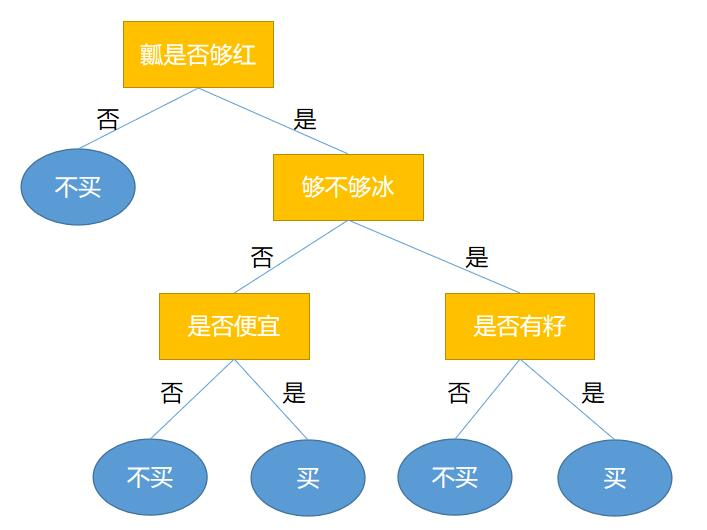

假设当模型在划分`是否便宜`这个结点前，模型在验证数据集上的正确率为`0.81`。但在划分后，模型在验证数据集上的正确率降为`0.67`。此时就不应该划分`是否便宜`这个结点。所以预剪枝后的模型如下：

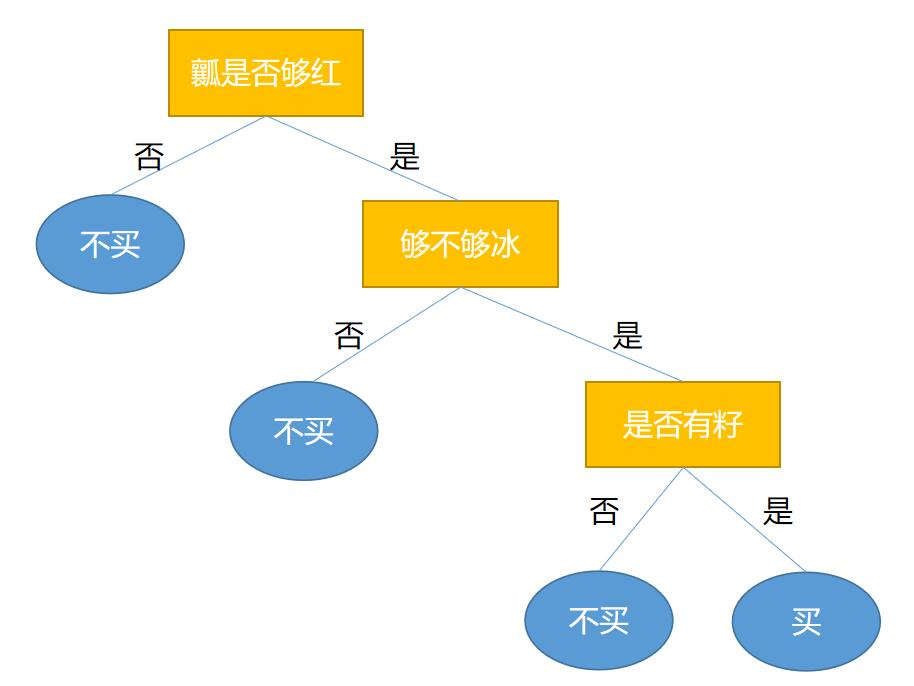

从上图可以看出，**预剪枝能够降低决策树的复杂度**。这种**预剪枝**处理属于**贪心思想**，但是贪心有一定的缺陷，就是可能当前划分会**降低泛化性能**，但在其基础上进行的后续划分却有可能导致性能显著提高。所以有可能会**导致决策树出现欠拟合**的情况。


#### 后剪枝

**后剪枝**是先从训练集生成一棵完整的决策树，然后**自底向上**地对非叶结点进行考察，若将该结点对应的子树替换为叶结点能够带来决策树泛化性能提升，则将该子树替换为叶结点。

**后剪枝**的**思路**很直接，对于决策树中的每一个非叶子结点的子树，我们尝试着把它替换成一个叶子结点，该叶子结点的类别我们用子树所覆盖训练样本中存在最多的那个类来代替，这样就产生了一个简化决策树，然后比较这两个决策树在测试数据集中的表现，如果简化决策树在验证数据集中的准确率有所提高，那么该子树就可以替换成叶子结点。该算法以bottom-up的方式遍历所有的子树，直至没有任何子树可以替换使得测试数据集的表现得以改进时，算法就可以终止。

从后剪枝的流程可以看出，**后剪枝**是从**全局的角度**来看待要不要**剪枝**，所以造成欠拟合现象的可能性比较小。但由于后剪枝需要先生成完整的决策树，然后再剪枝，所以后剪枝的**训练时间开销更高**。

### 实操练习

#### 编程要求

填写`fit(self, train_feature, train_label, val_featrue, val_label)`函数，实现带后剪枝的**ID3算法**，要求决策树保存在self.tree中。其中：

- `train_feature`：训练集数据，类型为`ndarray`，数值全为整数
- `train_label`：训练集标签，类型为`ndarray`，数值全为整数
- `val_feature`：验证集数据，类型为`ndarray`，数值全为整数；
- `val_label`：验证集标签，类型为`ndarray`，数值全为整数。

填写`predict(self, feature)`函数，实现预测功能，并将标签返回，其中：

- `feature`：测试集数据，类型为`ndarray`，数值全为整数。

#### 测试说明

输出预测准确率（应高于0.93)

In [51]:
import numpy as np
from copy import deepcopy

class DecisionTree(object):
    def __init__(self):
        #决策树模型
        self.tree = {}
    def calc_info_gain(self, feature, label, index):
        '''
        计算信息增益
        :param feature: 数据集中的特征，类型为ndarray，类型为ndarray
        :param label: 数据集中的标签，类型为ndarray，类型为ndarray
        :param index: feature特征列的索引,即feature中第几个特征
        :return: 信息增益，类型float
        '''
        # 计算熵
        def calc_info_entropy(label):
            '''
            计算信息熵
            :param feature:数据集中的特征，类型为ndarray
            :param label:数据集中的标签，类型为ndarray
            :return:信息熵，类型float
            '''
            label_set = set(label)
            result = 0
            for l in label_set:
                count = 0
                for j in range(len(label)):
                    if label[j] == l:
                        count += 1
                # 计算标签在数据集中出现的概率
                p = count / len(label)
                # 计算熵
                result -= p * np.log2(p)
            return result
        # 计算条件熵
        def calc_HDA(feature, label, index, value):
            '''
            计算信息熵
            :param feature:数据集中的特征，类型为ndarray
            :param label:数据集中的标签，类型为ndarray
            :param index:需要使用的特征列索引，类型为int
            :param value:index所表示的特征列中需要考察的特征值，类型为int
            :return:信息熵，类型float
            '''
            count = 0
            # sub_feature和sub_label表示根据特征列和特征值分割出的子数据集中的特征和标签
            sub_feature = []
            sub_label = []
            for i in range(len(feature)):
                if feature[i][index] == value:
                    count += 1
                    sub_feature.append(feature[i])
                    sub_label.append(label[i])
            pHA = count / len(feature)
            e = calc_info_entropy(sub_label)
            return pHA * e
        base_e = calc_info_entropy(label)
        f = np.array(feature)
        # 得到指定特征列的值的集合
        f_set = set(f[:, index])
        sum_HDA = 0
        # 计算条件熵
        for value in f_set:
            sum_HDA += calc_HDA(feature, label, index, value)
        # 计算信息增益
        return base_e - sum_HDA
    # 获得信息增益最高的特征
    def get_best_feature(self, feature, label):
        max_infogain = 0
        best_feature = 0
        for i in range(len(feature[0])):
            infogain = self.calc_info_gain(feature, label, i)
            if infogain > max_infogain:
                max_infogain = infogain
                best_feature = i
        return best_feature
    # 计算验证集准确率
    def calc_acc_val(self, the_tree, val_feature, val_label):
        result = []
        def classify(tree, feature):
            if not isinstance(tree, dict):
                return tree
            t_index, t_value = list(tree.items())[0]
            f_value = feature[t_index]
            if isinstance(t_value, dict):
                class_label = classify(tree[t_index][f_value], feature)
                return class_label
            else:
                return t_value
        for f in val_feature:
            result.append(classify(the_tree, f))
        result = np.array(result)
        return np.mean(result == val_label)
    
    def create_tree(self, train_feature, train_label):
        # 样本里都是同一个label没必要继续分叉了
        if len(set(train_label)) == 1:
            return train_label[0]
        # 样本中只有一个特征或者所有样本的特征都一样的话就看哪个label的票数高
        if len(train_feature[0]) == 1 or len(np.unique(train_feature, axis=0)) == 1:
            vote = {}
            for l in train_label:
                if l in vote.keys():
                    vote[l] += 1
                else:
                    vote[l] = 1
            max_count = 0
            vote_label = None
            for k, v in vote.items():
                if v > max_count:
                    max_count = v
                    vote_label = k
            return vote_label
        # 根据信息增益拿到特征的索引
        best_feature = self.get_best_feature(train_feature, train_label)
        tree = {best_feature: {}}
        f = np.array(train_feature)
        # 拿到bestfeature的所有特征值
        f_set = set(f[:, best_feature])
        # 构建对应特征值的子样本集sub_feature, sub_label
        for v in f_set:
            sub_feature = []
            sub_label = []
            for i in range(len(train_feature)):
                if train_feature[i][best_feature] == v:
                    sub_feature.append(train_feature[i])
                    sub_label.append(train_label[i])
            # 递归构建决策树
            tree[best_feature][v] = self.create_tree(sub_feature, sub_label)
        return tree
    # 后剪枝
    def post_cut(self, val_feature, val_label):
        # 拿到非叶子节点的数量
        def get_non_leaf_node_count(tree):
            non_leaf_node_path = []
            def dfs(tree, path, all_path):
                for k in tree.keys():
                    if isinstance(tree[k], dict):
                        path.append(k)
                        dfs(tree[k], path, all_path)
                        if len(path) > 0:
                            path.pop()
                    else:
                        all_path.append(path[:])
            dfs(tree, [], non_leaf_node_path)
            unique_non_leaf_node = []
            for path in non_leaf_node_path:
                isFind = False
                for p in unique_non_leaf_node:
                    if path == p:
                        isFind = True
                        break
                if not isFind:
                    unique_non_leaf_node.append(path)
            return len(unique_non_leaf_node)
        # 拿到树中深度最深的从根节点到非叶子节点的路径
        def get_the_most_deep_path(tree):
            non_leaf_node_path = []
            def dfs(tree, path, all_path):
                for k in tree.keys():
                    if isinstance(tree[k], dict):
                        path.append(k)
                        dfs(tree[k], path, all_path)
                        if len(path) > 0:
                            path.pop()
                    else:
                        all_path.append(path[:])
            dfs(tree, [], non_leaf_node_path)
            max_depth = 0
            result = None
            for path in non_leaf_node_path:
                if len(path) > max_depth:
                    max_depth = len(path)
                    result = path
            return result
        # 剪枝
        def set_vote_label(tree, path, label):
            for i in range(len(path)-1):
                tree = tree[path[i]]
            tree[path[len(path)-1]] = vote_label
            
        acc_before_cut = self.calc_acc_val(self.tree, val_feature, val_label)
        # 遍历所有非叶子节点
        for _ in range(get_non_leaf_node_count(self.tree)):
            path = get_the_most_deep_path(self.tree)
            # 备份树
            tree = deepcopy(self.tree)
            step = deepcopy(tree)
            # 跟着路径走
            for k in path:
                step = step[k]
            # 叶子节点中票数最多的标签
            vote_label = sorted(step.items(), key=lambda item: item[1], reverse=True)[0][0]
            # 在备份的树上剪枝
            set_vote_label(tree, path, vote_label)
            acc_after_cut = self.calc_acc_val(tree, val_feature, val_label)
            # 验证集准确率高于0.9才剪枝
            if acc_after_cut > acc_before_cut:
                set_vote_label(self.tree, path, vote_label)
                acc_before_cut = acc_after_cut
    def fit(self, train_feature, train_label, val_feature, val_label):
        '''
        :param train_feature:训练集数据，类型为ndarray
        :param train_label:训练集标签，类型为ndarray
        :param val_feature:验证集数据，类型为ndarray
        :param val_label:验证集标签，类型为ndarray
        :return: None
        '''
        #************* Begin ************#
        self.tree = self.create_tree(train_feature, train_label)
        # 后剪枝
        self.post_cut(val_feature, val_label)
        #************* End **************#
    def predict(self, feature):
        '''
        :param feature:测试集数据，类型为ndarray
        :return:预测结果，如np.array([0, 1, 2, 2, 1, 0])
        '''
        #************* Begin ************#
        result = []
        # 单个样本分类
        def classify(tree, feature):
            if not isinstance(tree, dict):
                return tree
            t_index, t_value = list(tree.items())[0]
            f_value = feature[t_index]
            if isinstance(t_value, dict):
                class_label = classify(tree[t_index][f_value], feature)
                return class_label
            else:
                return t_value
        for f in feature:
            result.append(classify(self.tree, f))
        return np.array(result)
        #************* End **************#

In [52]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 测试模型性能
iris = datasets.load_iris()
X = iris.data.astype(int)
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=233
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=233
)
dt = DecisionTree()
dt.fit(X_train, y_train, X_val, y_val)
predict = dt.predict(X_test)
acc = accuracy_score(y_test, predict)

print('预测正确率：{:.2f}'.format(acc))

预测正确率：0.97


## 7. 鸢尾花识别

### 任务描述

使用sklearn的决策树完成鸢尾花分类任务。

### 相关知识

为了完成本任务，需要掌握如何使用sklearn提供的DecisionTreeClassifier。

#### 数据简介

**鸢尾花数据集**是一类多重变量分析的数据集。通过花萼长度，花萼宽度，花瓣长度，花瓣宽度4个属性预测鸢尾花卉属于(Setosa，Versicolour，Virginica)三个种类中的哪一类(其中分别用0，1，2代替)。

sklearn中已经提供了鸢尾花数据集的相关接口，使用该数据集的代码如下：

In [54]:
from sklearn import datasets
import pandas as pd
#加载波斯顿房价数据集
iris = datasets.load_iris()
#X表示特征，y表示目标房价
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [62]:
iris_df['target'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


#### DecisionTreeClassifier

`DecisionTreeClassifier`的构造函数中有两个常用的参数可以设置：

- `criterion`:划分节点的标准。有`gini`（基尼系数）,`entropy`(信息增益)。若不设置，默认为gini
- `max_depth`:决策树的最大深度，如果发现模型已经出现过拟合，可以尝试将该参数调小。若不设置，默认为`None`

和`sklearn`中其他分类器一样，`DecisionTreeClassifier`类中的`fit`函数用于训练模型，`fit`函数有两个向量输入：

- `X`：大小为`(样本数量,特征数量)`的`ndarray`，存放训练样本
- `Y`：值为整型，大小为`(样本数量,)`的`ndarray`，存放训练样本的分类标签

`DecisionTreeClassifier`类中的`predict`函数用于预测，返回预测标签，`predict`函数有一个向量输入：

- `X`：大小为`(样本数量,特征数量)`的`ndarray`，存放预测样本

### 实操练习

#### 编程要求

补充python代码，实现鸢尾花数据的分类任务，并将对测试集的预测结果保存至./data/iris-predict.csv中。

#### 测试说明

输出预测的准确率，预测准确率应高于0.95。

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    iris.data.astype(int),
    iris.target,
    test_size=0.2, 
    random_state=1
)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
acc = accuracy_score(y_test, y_pred)

pred = pd.DataFrame({'target': y_pred})
pred.to_csv('./data/iris-predict.csv')

print('预测正确率：{:.2f}'.format(acc))

预测正确率：0.97
